# Imports 

In [42]:
from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk

import matplotlib.pyplot as plt

# Load Image

In [43]:
def load_itk(file_name: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads a medical image in ITK format and returns the image array, origin, and spacing.

    Parameters:
        file_name (str): Path to the ITK image file (e.g., .mhd or .nii).

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: 
            - img_arr (np.ndarray): The image data as a 3D NumPy array (depth, height, width).
            - origin (np.ndarray): The physical origin of the image in world coordinates (z, y, x).
            - spacing (np.ndarray): The voxel spacing in world coordinates (z, y, x).
    """
    itk_img = sitk.ReadImage(file_name)
    img_arr = sitk.GetArrayFromImage(itk_img)
    origin = np.array(list(reversed(itk_img.GetOrigin())))
    spacing = np.array(list(reversed(itk_img.GetSpacing())))
    
    return img_arr, origin, spacing

In [44]:
luna_subset_path = r"C:\Users\azizd\python\pytorch\data\bitirme_projesi\archive\subset0\subset0"
mhd_list = glob(luna_subset_path + "\\*.mhd")

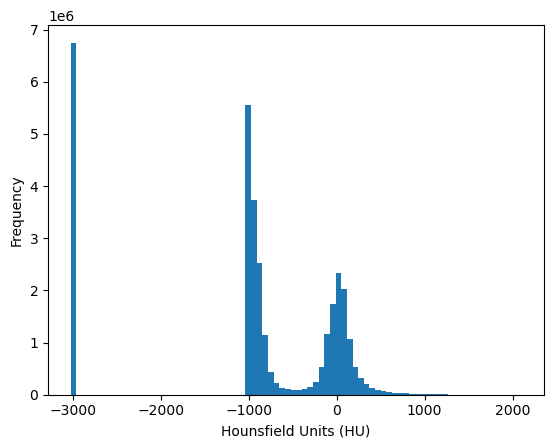

In [45]:
img_arr, origin, spacing = load_itk(mhd_list[0])
first_patient_img_arr = img_arr
plt.hist(first_patient_img_arr.flatten(), bins=80)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Resample Images to Isomorphic Spacing

In [46]:
def resample(img_arr: np.ndarray, old_spacing: np.ndarray, new_spacing=[1, 1, 1]) -> tuple[np.ndarray, np.ndarray] :
    """
    Resamples a 3D medical image to a new voxel spacing.

    Parameters:
        img_arr (np.ndarray): The input 3D image array (depth, height, width).
        old_spacing (np.ndarray): The original voxel spacing in world coordinates (z, y, x).
        new_spacing (list or np.ndarray, optional): The desired voxel spacing (default: [1, 1, 1]).

    Returns:
        tuple[np.ndarray, np.ndarray]: 
            - resampled_img (np.ndarray): The resampled image array with the new spacing.
            - adjusted_spacing (np.ndarray): The actual spacing after resampling, accounting for rounding errors.
    """
    spacing = np.array(old_spacing, dtype = np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = img_arr.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img_arr.shape
    new_spacing = spacing / real_resize_factor

    img_arr = scipy.ndimage.zoom(img_arr, real_resize_factor, mode="nearest")

    return img_arr, new_spacing

In [47]:
resampled_img, spacing2 = resample(img_arr, spacing)
print(img_arr.shape, spacing)
print(resampled_img.shape, spacing2)

(121, 512, 512) [2.5        0.76171899 0.76171899]
(302, 390, 390) [1.00165563 1.00000031 1.00000031]


# Removing Other Body Parts From Image
At the next step we would like to clean up the 3d array of CT Scan, because we like to tell our neural network to pay attention to really important parts, and not to get lost looking at a large amount of unnecessary information.

To reach this, we will go through these steps:

Convert the original 3d image into a binary image.
Remove the blobs connected to the border of the image.
Label the connected points of the image.
Keep the labels with 2 largest areas and segment two lungs.
Fill in the small holes inside the mask of lungs which we separate right and left lung.
Fill the convex hull of each lung.
Joint two separated right and left lungs.
Closure operation with a disk of radius 10. This operation is to keep nodules attached to the lung wall.
Superimpose the binary mask on the 
input image.
In summary, we segment lungs and make a mask from them, then throw away the voxels out of that mask at the original image.

In [48]:
def get_segmented_lungs(img_2d: np.ndarray, plot: bool=False) -> np.ndarray:
    plt_number = 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title('original_img')
        plots[plt_number].imshow(img_2d, cmap=plt.cm.bone)
        plt_number += 1

    # Thresholding to create a binary mask.
    binary_img = img_2d < -600 
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('binary_img')
        plots[plt_number].imshow(binary_img, cmap=plt.cm.bone)
        plt_number += 1
    
    # Removing border artifacts
    clear_img = clear_border(binary_img)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('clear_img')
        plots[plt_number].imshow(clear_img, cmap=plt.cm.bone)
        plt_number += 1
    
    # Labelling connected components (regions)
    labeled_img = label(clear_img)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('labeled_img1')
        plots[plt_number].imshow(labeled_img, cmap=plt.cm.bone)
        plt_number += 1
    
    # Extracting and sorting region ares
    areas = sorted(r.area for r in regionprops(labeled_img))

    # Filtering small regions (noise removal)
    labels = []
    if len(areas) > 2:
        for region in regionprops(labeled_img):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    labeled_img[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(labeled_img[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]

    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('labeled_img2')
        plots[plt_number].imshow(labeled_img, cmap=plt.cm.bone)
        plt_number += 1

    # Isolating left and right lung regions
    r_lung = labeled_img == labels[0]
    l_lung = labeled_img == labels[1]

    # Edge detection and hole filling
    r_edges = roberts(r_lung)
    l_edges = roberts(l_lung)
    r_lung = ndi.binary_fill_holes(r_edges)
    l_lung = ndi.binary_fill_holes(l_edges)

    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('r_lung1')
        plots[plt_number].imshow(r_lung, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title('l_lung1')
        plots[plt_number].imshow(l_lung, cmap=plt.cm.bone)
        plt_number += 1

    # Convex hull transformation. 
    r_lung = convex_hull_image(r_lung)
    l_lung = convex_hull_image(l_lung)

    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('r_lung2')
        plots[plt_number].imshow(r_lung, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title('l_lung2')
        plots[plt_number].imshow(l_lung, cmap=plt.cm.bone)
        plt_number += 1

    # Combining left and right lungs
    sum_of_lr = r_lung + l_lung
    binary_img = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('binary_img3')
        plots[plt_number].imshow(binary_img, cmap=plt.cm.bone)
        plt_number += 1
    
    # Morphological closing.
    selem = disk(10)
    binary_img = binary_closing(binary_img, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('binary_img4')
        plots[plt_number].imshow(binary_img, cmap=plt.cm.bone)
        plt_number += 1

    # Applying the final mask. Non-lung areas are set to zero
    get_high_vals = binary_img == 0
    result_img = img_2d.copy()
    result_img[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('result')
        plots[plt_number].imshow(result_img, cmap=plt.cm.bone)
        plt_number += 1
    
    return result_img

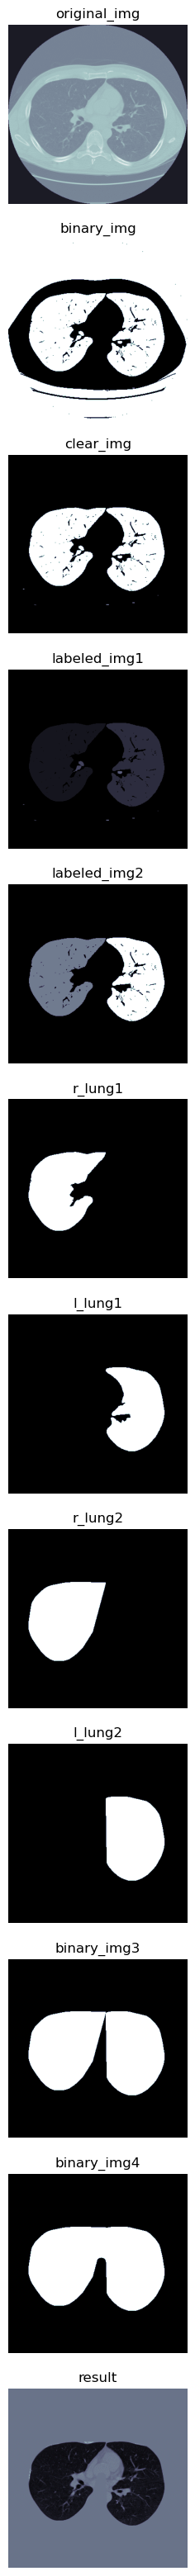

In [49]:
tmp_2d_img = get_segmented_lungs(resampled_img[150,:,:], True)

In [50]:
segmented_img = np.asarray([get_segmented_lungs(im) for im in resampled_img])

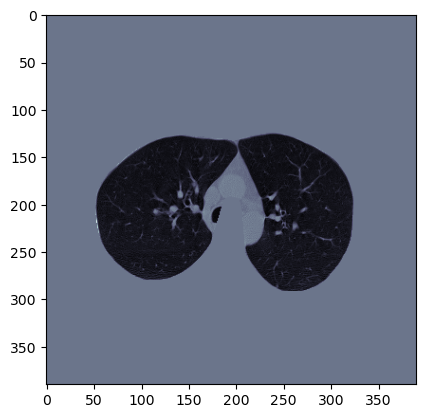

In [51]:
plt.imshow(segmented_img[201,:,:], cmap=plt.cm.bone)
plt.show()

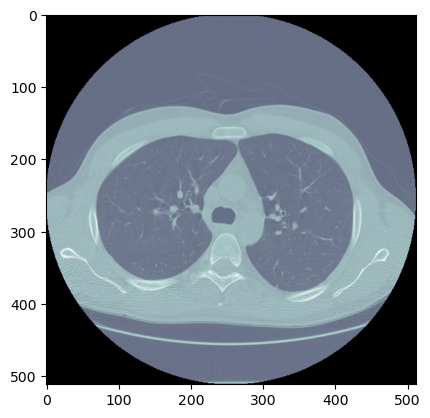

In [54]:
plt.imshow(first_patient_img_arr[int(201*121/302),:,:], cmap=plt.cm.bone)
plt.show()

In [55]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image_ = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image_[image_ > 1] = 1.
        image_[image_ < 0] = 0.
        image_ *= 255.
        normalized_img = image_
        return normalized_img
    

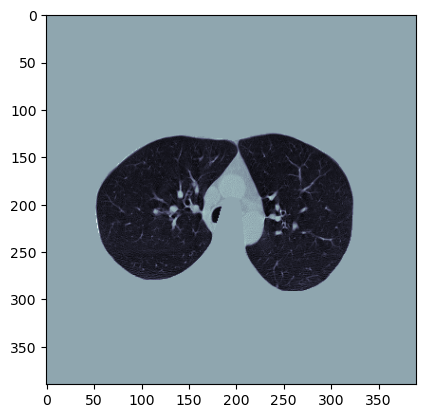

In [58]:
normalized_img = normalize(segmented_img)
plt.imshow(normalized_img[201,:,:], cmap=plt.cm.bone)
plt.show()

In [59]:
def zero_center(image):
    PIXEL_MEAN = 0.25 * 256
    image2 = image - PIXEL_MEAN
    return image2

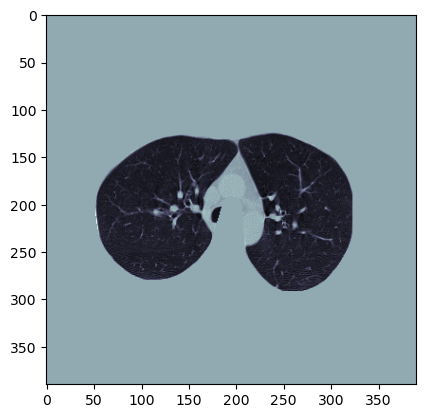

In [60]:
centered_img = zero_center(normalized_img)
plt.imshow(centered_img[200,:,:], cmap=plt.cm.bone)
plt.show()